# Pretrained Models

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

e:\emoevent-emotion-study\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading datasets

In [2]:
df_test = pd.read_csv('../data/es/test.tsv', sep='\t')

## 2. Preprocessing

### 2.1 Text Cleaning

In [3]:
df_test.dropna(inplace=True)

In [4]:
def clean_tweet(text: str) -> str:
    text = re.sub(r"@\w+", "<user>", text)
    text = re.sub(r"http\S+|www\S+", "<url>", text)
    text = re.sub(r"\d{5,}", "<number>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [5]:
df_test['clean_tweet'] = df_test['tweet'].apply(clean_tweet)

### 2.2 Tokenization

**Objetivo:** Definimos el *checkpoint* preentrenado que vamos a usar (`pysentimiento/robertuito-emotion-analysis`) y verificamos si tenemos GPU disponible para acelerar el proceso.  
- Si hay GPU → usamos `"cuda"`.  
- Si no → usamos `"cpu"`.  

Esto asegura que el modelo se ejecute en el mejor hardware disponible.

In [6]:
MODEL_NAME = "pysentimiento/robertuito-emotion-analysis"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


**Objetivo:** Cargar los componentes básicos del modelo.  
- **Tokenizer (`AutoTokenizer`)**: convierte texto en secuencias de *tokens* (sub-palabras) que el modelo entiende.  
- **Modelo (`AutoModelForSequenceClassification`)**: red neuronal preentrenada en emociones, lista para inferencia.  
- Usamos `.to(device)` para mover el modelo a GPU.
- Finalmente lo ponemos en modo `eval()` porque no vamos a entrenar, solo inferir.


In [7]:
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    use_safetensors=True
).to(device).eval()

In [8]:
id2label = model.config.id2label
label2id = {v: k for k, v in id2label.items()}
print(id2label)

{0: 'others', 1: 'joy', 2: 'sadness', 3: 'anger', 4: 'surprise', 5: 'disgust', 6: 'fear'}


In [9]:
# Verificar compatibilidad entre labels del modelo preentrenado y labels del dataset
df_test['emotion'].value_counts()

emotion
others      796
joy         348
sadness     195
anger       166
surprise     67
disgust      33
fear         21
Name: count, dtype: int64

In [10]:
import numpy as np, torch
import torch.nn.functional as F

def predict_labels_proba(texts, batch_size=128, max_len=128):
    preds_idx, all_probs = [], []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            enc = tok(texts[i:i+batch_size], padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
            logits = model(**enc).logits    # [B, C]
            p = F.softmax(logits, dim=-1).cpu().numpy()    # [B, C]
            all_probs.append(p)
            preds_idx.extend(p.argmax(axis=1).tolist())
    probs = np.vstack(all_probs)    # [N, C]
    preds = np.array([id2label[i] for i in preds_idx])    # [N]
    return preds, probs

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
)
from sklearn.preprocessing import label_binarize

class EvaluadorMulticlase:
    def __init__(self, classes):
        self.classes = list(classes)


    def show_classification_report(self, y_true_str, y_pred_str, title="Classification report"):
        df_rep = pd.DataFrame(
            classification_report(
                y_true_str, y_pred_str,
                labels=self.classes, target_names=self.classes,
                output_dict=True, zero_division=0
            )
        ).T.round(4)
        print(f"== {title} ==")
        display(df_rep)


    def show_confusion_matrix(self, y_true_str, y_pred_str, title="Matriz de confusión"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])
        y_pred_id = np.array([label2id[x] for x in y_pred_str])

        cm = confusion_matrix(y_true_id, y_pred_id, labels=list(range(len(self.classes))))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title(title); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout()
        plt.show()


    def show_roc_curves(self, y_true_str, probs, title="Curvas ROC (OvR)"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])

        Y_bin = label_binarize(y_true_id, classes=list(range(len(self.classes))))
        n = len(self.classes)
        rows = int(np.ceil(n/4))
        fig, axes = plt.subplots(rows, 4, figsize=(5*4, 4*rows))
        axes = np.atleast_2d(axes)
        auc_macro = None
        try:
            auc_macro = roc_auc_score(Y_bin, probs, average="macro", multi_class="ovr")
        except ValueError:
            pass

        for i, c in enumerate(self.classes):
            r, col = divmod(i, 4)
            ax = axes[r, col]
            try:
                fpr, tpr, _ = roc_curve(Y_bin[:, i], probs[:, i])
                auc_i = roc_auc_score(Y_bin[:, i], probs[:, i])
                ax.plot(fpr, tpr, label=f"AUC={auc_i:.3f}")
            except ValueError:
                ax.plot([0,1],[0,1],'--', lw=1)
                ax.text(0.5, 0.5, "Sin positivos", ha="center")
            ax.plot([0,1],[0,1],'--', lw=1)
            ax.set_title(f"ROC: {c}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right")

        # elimina ejes sobrantes
        total = rows*3
        if total > n:
            for j in range(n, total):
                r, col = divmod(j, 4)
                fig.delaxes(axes[r, col])

        supt = f"{title}" + (f" | AUC macro={auc_macro:.3f}" if auc_macro is not None else "")
        fig.suptitle(supt)
        plt.tight_layout()
        plt.show()


    def show_pr_curves(self, y_true_str, probs, title="Curvas Precision-Recall (OvR)"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])

        Y_bin = label_binarize(y_true_id, classes=list(range(len(self.classes))))
        n = len(self.classes)
        rows = int(np.ceil(n/4))
        fig, axes = plt.subplots(rows, 4, figsize=(5*4, 4*rows))
        axes = np.atleast_2d(axes)

        for i, c in enumerate(self.classes):        
            r, col = divmod(i, 4)
            ax = axes[r, col]
            try:
                precision, recall, _ = precision_recall_curve(Y_bin[:, i], probs[:, i])
                ap = average_precision_score(Y_bin[:, i], probs[:, i])
                ax.plot(recall, precision, label=f"AP={ap:.3f}")
            except ValueError:
                ax.plot([0,1],[1,0],'--', lw=1)
                ax.text(0.5, 0.5, "Sin positivos", ha="center")
            ax.set_title(f"PR: {c}")
            ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
            ax.legend(loc="lower left")

        total = rows*3
        if total > n:
            for j in range(n, total):
                r, col = divmod(j, 3)
                fig.delaxes(axes[r, col])

        fig.suptitle(title)
        plt.tight_layout()
        plt.show()


    # --- Análisis por evento (bloques con mini-tablas de distribuciones) ---
    def show_event_analysis(self, df, probs, y_col="emotion", event_col="event", title="Análisis por evento"):
        pred_ids = probs.argmax(axis=1)
        pred_str = np.array([self.classes[i] for i in pred_ids])

        tmp = df[[y_col, event_col]].copy()
        tmp["pred"] = pred_str

        print(f"== {title} ==")
        for event in sorted(tmp[event_col].unique()):
            sub = tmp[tmp[event_col] == event]

            # distribuciones
            dist_real = sub[y_col].value_counts().reindex(self.classes, fill_value=0)
            dist_pred = sub["pred"].value_counts().reindex(self.classes, fill_value=0)

            # métricas
            report = classification_report(
                sub[y_col], sub["pred"],
                labels=self.classes, target_names=self.classes,
                output_dict=True, zero_division=0
            )
            acc = accuracy_score(sub[y_col], sub["pred"])
            f1m = f1_score(sub[y_col], sub["pred"], average="macro")
            prec = report["macro avg"]["precision"]
            rec = report["macro avg"]["recall"]

            # mostrar métricas
            print(f"\nEvento: {event}")
            print(f"  Accuracy:        {acc:.4f}")
            print(f"  F1-macro:        {f1m:.4f}")
            print(f"  Precision-macro: {prec:.4f}")
            print(f"  Recall-macro:    {rec:.4f}")

            # mostrar tablas
            df_dist = pd.DataFrame({
                "Real": dist_real,
                "Pred": dist_pred
            }).astype(int)
            display(df_dist)

## Test

In [13]:
preds_test, probs_test = predict_labels_proba(df_test["clean_tweet"].tolist(), batch_size=128, max_len=128)

In [14]:
classes = list(model.config.id2label.values())
evalr = EvaluadorMulticlase(classes)

In [15]:
evalr.show_classification_report(df_test['emotion'], preds_test, title="Reporte de clasificación - Test")

== Reporte de clasificación - Test ==


,precision,recall,f1-score,support
others,0.5396,0.4962,0.5170,796.0000
joy,0.2414,0.3017,0.2682,348.0000
sadness,0.1538,0.1538,0.1538,195.0000
anger,0.1615,0.1867,0.1732,166.0000
surprise,0.0213,0.0149,0.0175,67.0000
disgust,0.0000,0.0000,0.0000,33.0000
fear,0.1200,0.1429,0.1304,21.0000
accuracy,0.3475,0.3475,0.3475,0.3475
macro avg,0.1768,0.1852,0.1800,1626.0000
weighted avg,0.3532,0.3475,0.3490,1626.0000


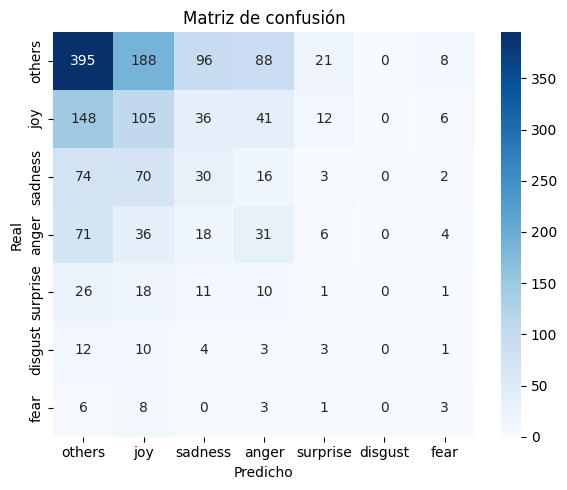

In [16]:
evalr.show_confusion_matrix(df_test['emotion'], preds_test)

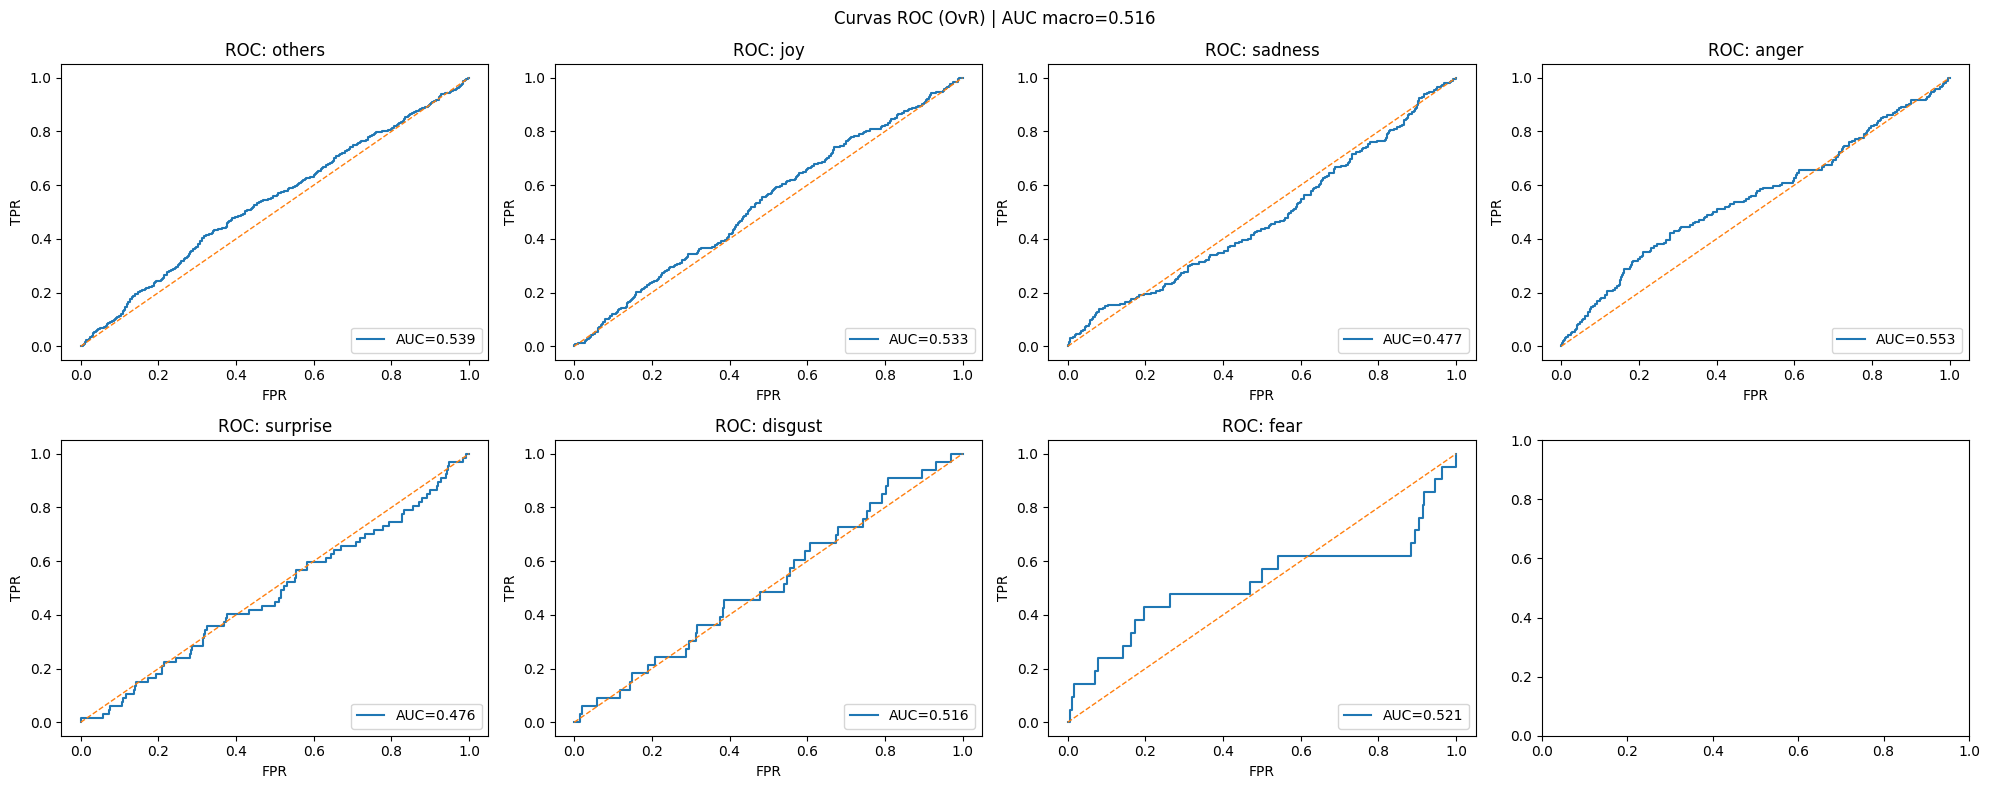

In [17]:
evalr.show_roc_curves(df_test['emotion'], probs_test)

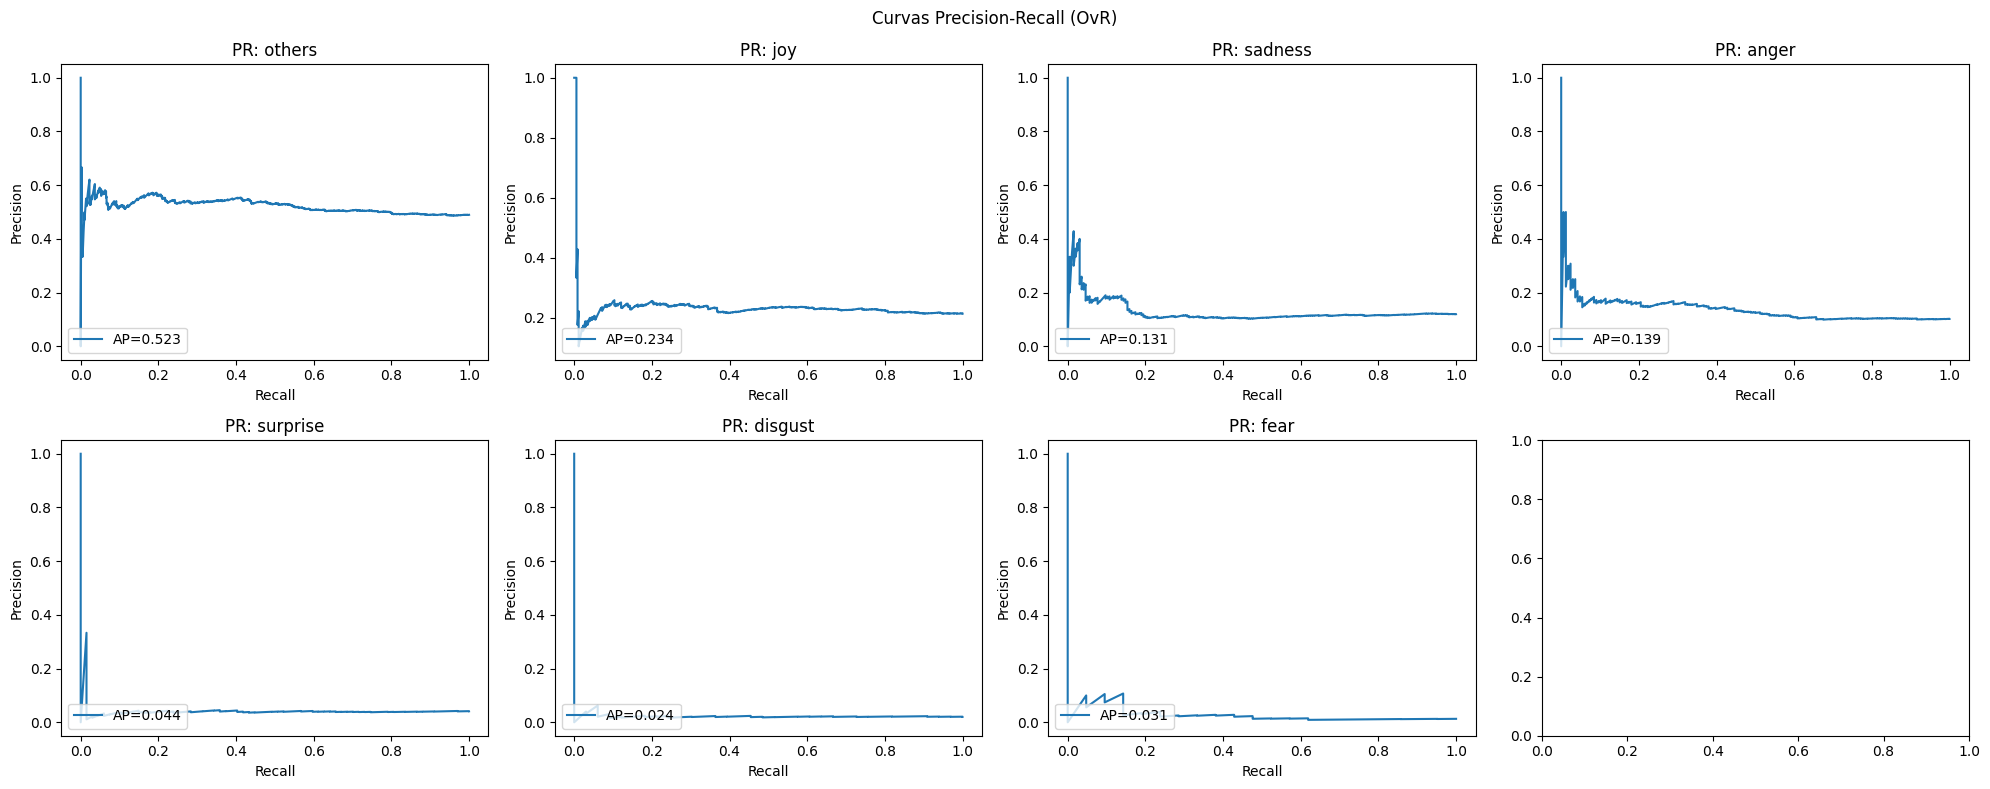

In [18]:
evalr.show_pr_curves(df_test['emotion'], probs_test)

In [19]:
evalr.show_event_analysis(df_test, probs_test, y_col="emotion", event_col="event", title="Análisis por evento - Test")

== Análisis por evento - Test ==

Evento: ChampionsLeague
  Accuracy:        0.3750
  F1-macro:        0.1393
  Precision-macro: 0.1320
  Recall-macro:    0.1528


,Real,Pred
others,99,131
joy,63,76
sadness,27,4
anger,30,18
surprise,5,2
disgust,6,0
fear,2,1



Evento: GameOfThrones
  Accuracy:        0.3196
  F1-macro:        0.1974
  Precision-macro: 0.1950
  Recall-macro:    0.2476


,Real,Pred
others,104,86
joy,47,60
sadness,27,16
anger,22,14
surprise,10,33
disgust,6,0
fear,3,10



Evento: GretaThunberg
  Accuracy:        0.4029
  F1-macro:        0.1647
  Precision-macro: 0.1790
  Recall-macro:    0.1739


,Real,Pred
others,68,89
joy,28,28
sadness,22,6
anger,12,15
surprise,6,0
disgust,1,0
fear,2,1



Evento: LaLiga
  Accuracy:        0.4034
  F1-macro:        0.1263
  Precision-macro: 0.1138
  Recall-macro:    0.1418


,Real,Pred
others,57,70
joy,32,41
sadness,7,3
anger,13,3
surprise,5,1
disgust,3,0
fear,2,1



Evento: NotreDame
  Accuracy:        0.2667
  F1-macro:        0.1254
  Precision-macro: 0.1838
  Recall-macro:    0.1777


,Real,Pred
others,122,58
joy,38,5
sadness,26,131
anger,23,29
surprise,12,1
disgust,4,0
fear,0,1



Evento: SpainElection
  Accuracy:        0.3486
  F1-macro:        0.1891
  Precision-macro: 0.1949
  Recall-macro:    0.2063


,Real,Pred
others,107,80
joy,46,74
sadness,21,11
anger,22,35
surprise,12,7
disgust,5,0
fear,5,11



Evento: Venezuela
  Accuracy:        0.3590
  F1-macro:        0.1567
  Precision-macro: 0.1619
  Recall-macro:    0.1860


,Real,Pred
others,124,111
joy,42,28
sadness,30,19
anger,21,73
surprise,10,3
disgust,3,0
fear,4,0



Evento: WorldBookDay
  Accuracy:        0.3500
  F1-macro:        0.1267
  Precision-macro: 0.1345
  Recall-macro:    0.1515


,Real,Pred
others,115,107
joy,52,123
sadness,35,5
anger,23,5
surprise,7,0
disgust,5,0
fear,3,0
